## Imports

In [1]:
# Data Analysis
import os
from tqdm import tqdm
import zipfile
import numpy as np
from numpy import asarray
from numpy import save
from numpy import load

# Scikit Learn
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Visualization
from matplotlib import pyplot as plt
#%matplotlib inline
import seaborn as sns

# Tensorflow 2.0
import tensorflow as tf
print(f"Tensorflow Version: {tf.__version__}")
%load_ext tensorboard
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Conv2DTranspose, Reshape, concatenate, RepeatVector
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
print(f"Imported Tensorflow")

# Scikit Learn image processing
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
print(f"Imported Scikit Learn Image Processing tools")

Tensorflow Version: 2.3.1
Imported Tensorflow
Imported Scikit Learn Image Processing tools


In [2]:
from utils import *  

Tensorflow Version: 2.3.1


## Utilities

In [3]:
def load_pretrained_vgg19_embedding(pretrained_weights):
    
    # Construct VGG19 model without the classifer and weights trained on imagenet data
    # '''Takes (224, 224, 3) RGB and returns the embeddings(predicions) generated on the RGB image'''
    feature_extractor = VGG19(input_shape=(224, 224, 3),
                              include_top = False)
    
    x = feature_extractor.output
    flat = Flatten()(x)
    fc_1 = Dense(1024, activation='relu')(flat)
    do_1 = Dropout(0.2)(fc_1)
    fc_2 = Dense(512, activation='relu')(do_1)
    do_2 = Dropout(0.3)(fc_2)
    output = Dense(9, activation= 'softmax')(do_2)

    embed_model = Model(feature_extractor.inputs, output)
    # Compile model
    embed_model.compile(loss="categorical_crossentropy",
                        optimizer=tf.keras.optimizers.Adam(lr=0.0004),
                        metrics=["accuracy"])
    
    print("Model Compiled")
    
    embed_model.load_weights(pretrained_weights)
    print("Loaded Finetuned Weights")
    
    return embed_model


def block(x, n_convs, filters, strides, activation, block_name):
    '''
    This functions defines a convolution layer(s) in the encoder network.
    Couples a BatchNormalization layer after a convolution layer.
    '''
    for i in range(n_convs):
        x = tf.keras.layers.Conv2D(filters=filters, kernel_size=(3,3), 
                                   strides = strides,activation=activation, 
                                   padding='same', name=f"{block_name}_conv{i+1}")(x)
        
        x = tf.keras.layers.BatchNormalization(name=f"{block_name}_batch_normalization{i+1}")(x)
    return x


def Colorization_Model():
    """
    Builds the entire Neural Coloring model architecture
    """
    embed_input = Input(shape=(9,), name="pretrained_model_output") # Prediction from the classifier
    visible = Input(shape=(224,224,1), name="input_image")          # Input image - L channel from 
                                                                    # Lab color space
    
    # Encoder
    ## Low Level Features Network
    x = block(visible, 1, 64, (2,2), 'relu', 'LL1')
    x = block(x, 1, 128, (1,1), 'relu', 'LL2')
    x = block(x, 1, 128, (2,2), 'relu', 'LL3')
    x = block(x, 1, 256, (1,1), 'relu', 'LL4')
    x = block(x, 1, 256, (2,2), 'relu', 'LL5')
    x = block(x, 1, 512, (1,1), 'relu', 'LL6')
    
    ## Mid-Level Features Network
    # The shape of mid-level network output is a (256, 28, 28) or 784 pixels for each filter
    # This layer shape determines the number of copies of embedding vectors to generate
    x = block(x, 1, 512, (1,1), 'relu', 'ML1')
    x = block(x, 1, 256, (1,1), 'relu', 'ML2')
    
    ## Bridge Network
    # bridge connecting the mid level features with the VGG19 classification output
    # Helps the encoder-decoder model to learn features of each class for better colorization  
    fusion_output = RepeatVector(28*28)(embed_input) # generates 784 copies of the classifier embedding (9,)
    fusion_output = Reshape(([28, 28, 9]))(fusion_output) # Reshape 784 to (28,28,9)
    fusion_output = tf.keras.layers.concatenate([x, fusion_output], axis=-1) # Attach this (28,28,9) to (28,28,256)
    fusion_output = block(fusion_output, 1, 256, (1,1), 'relu', 'FuL')
    
    ## Decoder Network
    decoder_output = block(fusion_output, 1, 128, (1,1), 'relu', 'DL1')
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = block(decoder_output, 1, 64, (1,1), 'relu', 'DL2')
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = block(decoder_output, 1, 32, (1,1), 'relu', 'DL3')
    decoder_output = block(decoder_output, 1, 16, (1,1), 'relu', 'DL4')
    decoder_output = block(decoder_output, 1,  2, (1,1), 'tanh', 'DL5')
    decoder_output = UpSampling2D((2, 2), name='colorization')(decoder_output)
    
    # Define inputs, outputs and compile the model 
    model = Model(inputs = [visible, embed_input], outputs = [decoder_output])
    optimizer = tf.keras.optimizers.RMSprop(lr=0.001)
    model.compile(optimizer=optimizer, 
                loss = 'mse',
                metrics = tf.keras.metrics.RootMeanSquaredError())
    
    return model

def getImages(filelist, transform_size=(224, 224, 3)):
    """Reads image filelist from DATASET and returns float represtation of RGB [0.0, 1.0]"""
    img_list = []
    for filename in tqdm(filelist):
        # 1. Loads JPEG image and converts it to numpy float array.
        image_in = img_to_array(load_img(filename))
        
        # 2. Normalizes the pixel values [0.0, 255.0] => [0.0, 1.0]
        image_in = image_in/255
        # 3. Resizes the image to the desired size
        if transform_size is not None:
            image_in = resize(image_in, transform_size, mode='reflect')
        # 4. Appends the image to a image list
        img_list.append(image_in)
    # 5. convert the images as a numpy array and return the numpy array   
    img_list = np.array(img_list)
    
    return img_list

def preprocess_images(rgb, embed_model, input_size=(224,224,3), embed_size=(224,224,3)):
    """
    This function performs does two things:
    A - Generates the embedding for an RGB image using the classifier.
    B - Converts the image from a RGB colorspace to Lab colorspace and
        separates the L and ab images
    """
    
    # A - generate embedding
    # 1. Resize for embed and convert to rgb 
    gray = gray2rgb(rgb2gray(rgb))
    gray = batch_apply(gray, resize, embed_size, mode='constant')
    # 2. Zero-Center [-1,1]
    gray = gray * 2 - 1
    # 3. generate embeddings using the classifier
    embed = create_pretrained_embedding(embed_model, gray)
    
    # B - Convert to 'Lab' colorspace and extract 'L' and 'ab channels'
    # Resize to input size of model
    re_batch = batch_apply(rgb, resize, input_size, mode='constant')
    # RGB => L*a*b*
    re_batch = batch_apply(re_batch, rgb2lab)

    # Extract L* into X, zero-center and normalize
    X_batch = re_batch[:,:,:,0]
    X_batch = X_batch/50 - 1
    X_batch = X_batch.reshape(X_batch.shape+(1,))

    # Extract a*b* into Y and normalize. Already zero-centered.
    Y_batch = re_batch[:,:,:,1:]
    Y_batch = Y_batch/128

    return [X_batch, embed], Y_batch


def image_a_b_gen(images, batch_size, embed_model):
    """
    From a large set of images this function preprocces batches of images.
    Preprocessing yields X(gray) and Y(ab channels) for training.
    """
    for batch in datagen.flow(images, batch_size=batch_size):
        yield preprocess_images(batch, embed_model)
        

def train(model, embed_model, training_files, batch_size=20, epochs=500, steps_per_epoch=50):
    """Trains the model"""
    # 1. Generate normalized and resized training files
    training_set = getImages(training_files)
    
    # 2. Define the size of training files -> 85% of the training set
    train_size = int(len(training_set)*0.85)
    
    # 3. Slice the file list to the training size defined above
    train_images = training_set[:train_size]
    
    # 4. Set the remaining images as validation data
    val_images = training_set[train_size:]
    
    # 5. Define validation step
    val_steps = (len(val_images)//batch_size)
    
    print("Training samples:", train_size, "Validation samples:", len(val_images))
    
    # 6. List necessary callbacks needed during training
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, verbose=1, min_delta=1e-5),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, cooldown=0, verbose=1, min_lr=1e-8),
        ModelCheckpoint(monitor='val_loss', filepath='model/colorize.hdf5', verbose=1,
                         save_best_only=True, save_weights_only=True, mode='auto'),
        TensorBoard(log_dir='/logs/fit/', histogram_freq=1, batch_size=20, write_graph=True, write_grads=True,
                    write_images=False, embeddings_freq=0),
        CSVLogger("/logs/training.log",separator=",", append=False)
    ]
    # Fit the model on batches on preprocessed train images
    model.fit_generator(image_a_b_gen(train_images, batch_size, embed_model), epochs=epochs, steps_per_epoch=steps_per_epoch,
                        verbose=1, callbacks=callbacks, validation_data=preprocess_images(val_images, embed_model))

        
def batch_apply(ndarray, func, *args, **kwargs):
    """Calls func with samples, func should take ndarray as first positional argument"""

    batch = []
    for sample in ndarray:
        batch.append(func(sample, *args, **kwargs))
    return np.array(batch)

def create_pretrained_embedding(embed_model, rgb):
    """
    This function uses the pretrained CRC classifier and 
    returns the embedding that predicts the tissue class 
    for a given RGB image
    """
    return embed_model.predict(rgb)

def plot_performance(hist, model_name):
    """
    Plots the accuracy and loss during the training process.
    Args: 
    history: variable assigned to model.fit()
    model_name: A string identifying the model
    """
    fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
    fig.suptitle("{} Training".format(model_name), fontsize=20)

    max_epoch = len(hist.history['accuracy'])+1
    epochs_list = list(range(1, max_epoch))

    ax1.plot(epochs_list, hist.history['accuracy'], color='b', linestyle='-', label='Training Data')
    ax1.plot(epochs_list, hist.history['val_accuracy'], color='r', linestyle='-', label ='Validation Data')
    ax1.set_title('Accuracy', fontsize=14)
    ax1.set_xlabel('Epochs', fontsize=14)
    ax1.set_ylabel('Accuracy', fontsize=14)
    ax1.legend(frameon=False, loc='lower center', ncol=2)

    ax2.plot(epochs_list, hist.history['loss'], color='b', linestyle='-', label='Training Data')
    ax2.plot(epochs_list, hist.history['val_loss'], color='r', linestyle='-', label ='Validation Data')
    ax2.set_title('Loss', fontsize=14)
    ax2.set_xlabel('Epochs', fontsize=14)
    ax2.set_ylabel('Loss', fontsize=14)
    ax2.legend(frameon=False, loc='upper center', ncol=2)
    
    if figure_directory:
        plt.savefig(figures+"/history")
    plt.show()

In [5]:
!pwd

/Users/rajesharasada/Documents/DataScience/neural_colorization-workspace


In [4]:
pretrained_weights = '../models/vgg19_model_finetuned.h5'

In [6]:
my_model = Colorization_Model()

In [9]:
train_dir = '/Users/rajesharasada/Documents/DataScience/neural_colorization-workspace/input/crc/NCT-CRC-HE-100K'
os.listdir(train_dir)

In [8]:
DATASET = []
for folder in os.listdir(train_dir):
    if folder != ".DS_Store":
        subfolder = os.path.join(train_dir,folder)
        for fname in os.listdir(subfolder):
            #print(fname)
            DATASET.append(os.path.join(subfolder, fname))

DATASET[:5]

['/floyd/input/crc/NCT-CRC-HE-100K/TUM/TUM-RVIQKNST.tif',
 '/floyd/input/crc/NCT-CRC-HE-100K/TUM/TUM-HKQPGCSW.tif',
 '/floyd/input/crc/NCT-CRC-HE-100K/TUM/TUM-DDGVVTHE.tif',
 '/floyd/input/crc/NCT-CRC-HE-100K/TUM/TUM-EFFWDMPA.tif',
 '/floyd/input/crc/NCT-CRC-HE-100K/TUM/TUM-FMRFGRIT.tif']

In [9]:
# Shuffle the files
dataset = shuffle(DATASET)

In [10]:
# Split the dataset into training and testing files
# The entire dataset with 100000 images is too large
# Hence only 40,000 images were used
training_files, testing_files = train_test_split(dataset[:40000], test_size=0.15)

In [11]:
# Length of the training set
len(training_files)

34000

In [12]:
# Images were augmented
datagen = ImageDataGenerator(shear_range=0.2,
                             zoom_range=0.2,
                             rotation_range=20,
                             horizontal_flip=True)

In [13]:
embed_model = load_pretrained_vgg19_embedding(pretrained_weights)

80142336/80134624 [==============================] - 1s 0us/step
Model Compiled
Loaded Finetuned Weights


In [14]:
batch_size=50

In [16]:
history = train(model = my_model, embed_model = embed_model, training_files = training_files, epochs=100)

100%|██████████| 34000/34000 [07:18<00:00, 77.48it/s] 


Training samples: 28900 Validation samples: 5100
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
50/50 [==============================] - ETA: 0s - loss: 0.8741 - root_mean_squared_error: 0.9349
Epoch 00001: val_loss improved from inf to 0.69528, saving model to model/colorize.hdf5
50/50 [==============================] - 86s 2s/step - loss: 0.8741 - root_mean_squared_error: 0.9349 - val_loss: 0.6953 - val_root_mean_squared_error: 0.8338 - lr: 0.0010
Epoch 2/100
50/50 [==============================] - ETA: 0s - loss: 0.7531 - root_mean_squared_error: 0.8678
Epoch 00002: val_loss improved from 0.69528 to 0.65983, saving model to model/colorize.hdf5
50/50 [==============================] - 82s 2s/step - loss: 0.7531 - root_mean_squared_error: 0.8678 - val_loss: 0.6598 - val_root_mean_squared_error: 0.8123 - lr: 0.0010
Epoch 3/100
50/50 [==============================] - ETA: 0s - loss: 0.6630 - root_mean_squared_error: 0.8142
Epoch 00003: val_loss

In [20]:
def test(model, embed_model, testing_files, save_actual=False, save_gray=False):
    print("Started")
    test_images = getImages(testing_files)
    
    model.load_weights(filepath='model/colorize.hdf5')

    print('Preprocessing Images')
    X_test, Y_test = preprocess_images(test_images, embed_model)
    
    print('Predicting')
    # Test model
    output = model.predict(X_test)
    
    # Rescale a*b* back. [-1.0, 1.0] => [-128.0, 128.0]
    output = output * 128
    Y_test = Y_test * 128

    # Output colorizations
    for i in range(len(output)):
        name = testing_files[i].split(".")[0].split("/")[-1]
        print('Saving '+str(i)+"th image " + name + ".png")
        
        lightness = X_test[0][i][:,:,0]
        
        #Rescale L* back. [-1.0, 1.0] => [0.0, 100.0]
        lightness = (lightness + 1) * 50
        
        predicted = np.zeros((224, 224, 3))
        predicted[:,:,0] = lightness
        predicted[:,:,1:] = output[i]
        plt.imsave("results/predicted/" + name + ".jpeg", lab2rgb(predicted))
        
        if save_gray:
            bnw = np.zeros((224, 224, 3))
            bnw[:,:,0] = lightness
            plt.imsave("results/bnw/" + name + ".jpeg", lab2rgb(bnw))
        
        if save_actual:
            actual = np.zeros((224, 224, 3))
            actual[:,:,0] = lightness
            actual[:,:,1:] = Y_test[i]
            plt.imsave("results/actual/" + name + ".jpeg", lab2rgb(actual))

In [22]:
test(my_model, embed_model, testing_files, True, True)

  0%|          | 18/6000 [00:00<00:34, 175.27it/s]

Started


100%|██████████| 6000/6000 [00:52<00:00, 114.68it/s]


Preprocessing Images
Predicting
Saving 0th image DEB-SPGVHDHD*.png
Saving 1th image DEB-FQTFKTFL*.png
Saving 2th image ADI-PYFRQDDQ*.png
Saving 3th image MUC-TNNIYQSL*.png
Saving 4th image MUC-GPNRDRKL*.png
Saving 5th image BACK-DMQEYPHS*.png
Saving 6th image BACK-GRTDAFGA*.png
Saving 7th image STR-KYYLEFHQ*.png
Saving 8th image LYM-RMRLYNFP*.png
Saving 9th image DEB-HGRFIAHP*.png
Saving 10th image MUS-EPHWRLHV*.png
Saving 11th image DEB-WFRHPSFS*.png
Saving 12th image BACK-NKGWIYAF*.png
Saving 13th image NORM-EGKCNEMH*.png
Saving 14th image DEB-KPGYQKRF*.png
Saving 15th image MUC-KPYIEYCI*.png
Saving 16th image MUS-SGEEVMRC*.png
Saving 17th image BACK-NNASHDDF*.png
Saving 18th image ADI-CICPHIQH*.png
Saving 19th image NORM-YCWSIFIT*.png
Saving 20th image TUM-GFLGSSHD*.png
Saving 21th image MUS-MSLKQCMM*.png
Saving 22th image LYM-DCVDMKFV*.png
Saving 23th image BACK-FGVNNMQL*.png
Saving 24th image TUM-IWTQFEHG*.png
Saving 25th image ADI-GAACKIPF*.png
Saving 26th image STR-KMTQILTQ*.png

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 168th image TUM-EHPIYTSF*.png
Saving 169th image MUS-NSGDYTLP*.png
Saving 170th image LYM-NECPGDMS*.png
Saving 171th image TUM-MGGDRMFC*.png
Saving 172th image ADI-ECYFTYYC*.png
Saving 173th image NORM-CNRWAQQQ*.png
Saving 174th image BACK-CDNTFSPF*.png
Saving 175th image TUM-KLCRKVSN*.png
Saving 176th image ADI-RTVRYAFS*.png
Saving 177th image BACK-FWIMGGYI*.png
Saving 178th image TUM-YIFCGIFE*.png
Saving 179th image STR-IIQVLKKT*.png
Saving 180th image BACK-NGRIQSER*.png
Saving 181th image MUS-KPWLNIKR*.png
Saving 182th image BACK-AKYHNNKW*.png
Saving 183th image BACK-GSMFKKTH*.png
Saving 184th image STR-PEKGMPVY*.png
Saving 185th image ADI-SGEVKAWK*.png
Saving 186th image BACK-AMCDIAAA*.png
Saving 187th image BACK-MVIGIVYM*.png
Saving 188th image MUS-IIELEAFG*.png
Saving 189th image MUS-ALKLFFNW*.png
Saving 190th image DEB-QPAFAAEK*.png
Saving 191th image DEB-GCGMGFHH*.png
Saving 192th image TUM-TNNGCIET*.png
Saving 193th image MUC-HKWTTGIC*.png
Saving 194th image MUS-LEGECLD

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 855th image MUC-NQQNPEKV*.png
Saving 856th image DEB-TYGTGCMN*.png
Saving 857th image STR-LDLRWKMT*.png
Saving 858th image TUM-RACQRLVY*.png
Saving 859th image MUS-TCEMHQRK*.png
Saving 860th image MUC-LFTAWKKP*.png
Saving 861th image DEB-RIVLSCCE*.png
Saving 862th image MUS-KLPSPTWD*.png
Saving 863th image DEB-FQYRYTGD*.png
Saving 864th image TUM-LNTCIVDN*.png
Saving 865th image TUM-IMMLQPWD*.png
Saving 866th image STR-NYWQCPDE*.png
Saving 867th image STR-DHFKHIQY*.png
Saving 868th image MUS-ACHEGAVH*.png
Saving 869th image DEB-DTYNPSKV*.png
Saving 870th image LYM-NHRQGCLM*.png
Saving 871th image TUM-FIQPTIER*.png
Saving 872th image TUM-MQYEIWKM*.png
Saving 873th image NORM-VDCGQTYP*.png
Saving 874th image ADI-MQIFSLRF*.png
Saving 875th image MUS-AGVTELMP*.png
Saving 876th image MUS-SALNFADG*.png
Saving 877th image MUS-TMLWDGDV*.png
Saving 878th image NORM-WKPRQAWR*.png
Saving 879th image ADI-HAMQYWHC*.png
Saving 880th image TUM-PIWRLYND*.png
Saving 881th image MUC-VPFILDTS*.png

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 5 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 1131th image MUS-APFAWFGD*.png
Saving 1132th image LYM-NWCSLFPN*.png
Saving 1133th image TUM-DLWRHYAE*.png
Saving 1134th image BACK-DKCLYNMM*.png
Saving 1135th image DEB-DMTAQQEE*.png
Saving 1136th image LYM-PIGHSEIW*.png
Saving 1137th image MUS-IFHGYCMR*.png
Saving 1138th image BACK-KFRSYRNV*.png
Saving 1139th image MUS-MSVGICMS*.png
Saving 1140th image ADI-KKEGVMTM*.png
Saving 1141th image TUM-SYTMDIHD*.png
Saving 1142th image BACK-AVCFQDDG*.png
Saving 1143th image BACK-FWAHQPMW*.png
Saving 1144th image TUM-NDLRGNQI*.png
Saving 1145th image MUS-GHADMYAA*.png
Saving 1146th image ADI-KEMYGHRS*.png
Saving 1147th image MUS-MKDVNRFF*.png
Saving 1148th image ADI-PDKYAYTF*.png
Saving 1149th image NORM-HTTTCHQC*.png
Saving 1150th image DEB-AVASHCVR*.png
Saving 1151th image TUM-MWNDDYEC*.png
Saving 1152th image STR-EMPEKCVA*.png
Saving 1153th image DEB-TECQKCPW*.png
Saving 1154th image NORM-QRIWALDG*.png
Saving 1155th image MUC-RYRPCIIR*.png
Saving 1156th image TUM-FGSFRSQW*.png
Saving

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 68 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 5202th image NORM-WFMNFHAE*.png
Saving 5203th image ADI-ECAAEISE*.png
Saving 5204th image ADI-QERNDEWM*.png
Saving 5205th image LYM-CWNRCSLH*.png
Saving 5206th image LYM-GFLPLYEE*.png
Saving 5207th image BACK-EWSEATDN*.png
Saving 5208th image NORM-IEGKMWNI*.png
Saving 5209th image BACK-ATRKRVED*.png
Saving 5210th image LYM-EAQVAIVS*.png
Saving 5211th image MUC-TWIYFRIL*.png
Saving 5212th image DEB-RFDFFGFE*.png
Saving 5213th image TUM-LHVYYTFP*.png
Saving 5214th image ADI-DIGCNFFC*.png
Saving 5215th image LYM-QCNHREEE*.png
Saving 5216th image TUM-MNNFCLIN*.png
Saving 5217th image LYM-PTSHMDVQ*.png
Saving 5218th image NORM-LNPVIHHP*.png
Saving 5219th image TUM-SVWIWMGS*.png
Saving 5220th image ADI-MDFDLSQH*.png
Saving 5221th image LYM-PYLSDSAY*.png
Saving 5222th image MUS-PCQEKCKQ*.png
Saving 5223th image MUS-LWCIPSTG*.png
Saving 5224th image LYM-ITGYIMRV*.png
Saving 5225th image NORM-GTQPMEAY*.png
Saving 5226th image ADI-KGSPAKEH*.png
Saving 5227th image MUC-SAGDFPII*.png
Saving

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 44 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 5955th image ADI-PWILDQSK*.png
Saving 5956th image ADI-FHIYFLAE*.png
Saving 5957th image DEB-HLTFVYNL*.png
Saving 5958th image MUS-KLAELNKV*.png
Saving 5959th image MUC-NLATSFLH*.png
Saving 5960th image BACK-NGSTHTWH*.png
Saving 5961th image TUM-MWNCGMMD*.png
Saving 5962th image MUS-IAHYGHQG*.png
Saving 5963th image ADI-NPIQFRFC*.png
Saving 5964th image MUS-QRCCFDWD*.png
Saving 5965th image MUC-YCLDHTWP*.png
Saving 5966th image LYM-YNNNHEHN*.png
Saving 5967th image STR-WWQISYRA*.png
Saving 5968th image ADI-LTTWQWND*.png
Saving 5969th image MUS-EFPQAGNC*.png
Saving 5970th image LYM-YSEHCHWI*.png
Saving 5971th image MUC-KKKWEQFV*.png
Saving 5972th image TUM-VIPVNDCG*.png
Saving 5973th image ADI-NSDAQSYQ*.png
Saving 5974th image NORM-APTDENAN*.png
Saving 5975th image ADI-IVRYSHAD*.png
Saving 5976th image MUC-PRATGVDL*.png
Saving 5977th image NORM-MHFVFWEF*.png
Saving 5978th image MUS-KCAEYDDV*.png
Saving 5979th image DEB-NRMTSWNK*.png
Saving 5980th image ADI-NIRMCNPR*.png
Saving 59

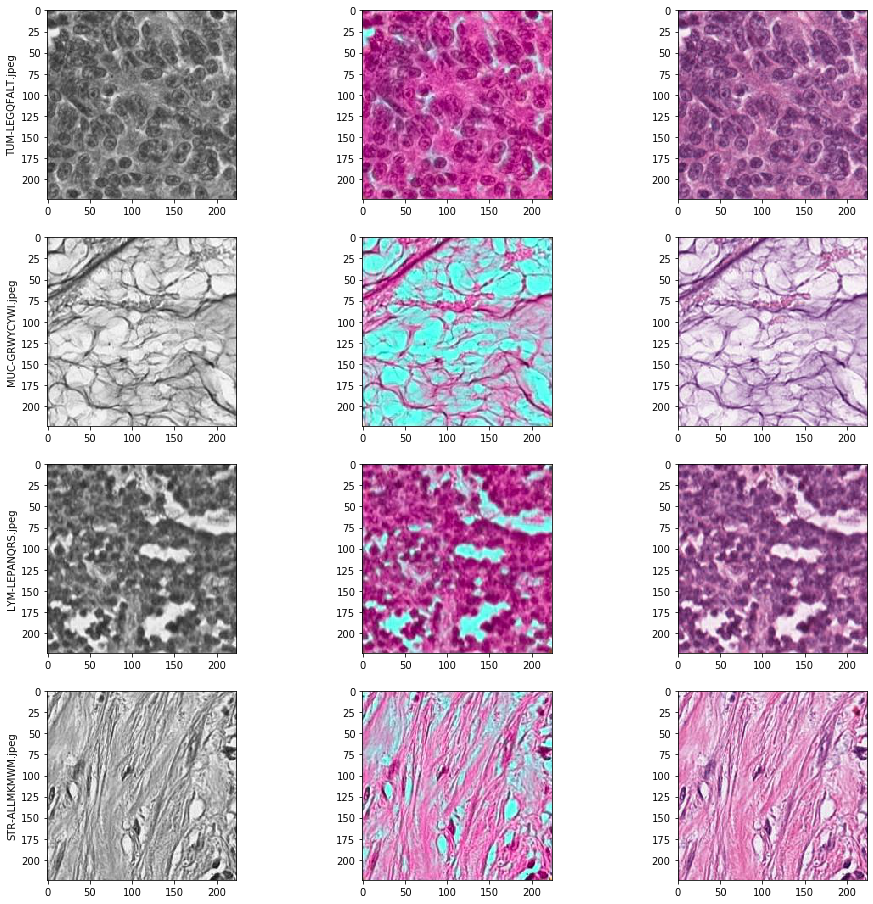

In [14]:
# Select random 4 results to display.
# Order: Input, Predicted, Ground Truth
# Assumes all three results folder have the 4 files

filelist = shuffle(os.listdir('results/predicted/'))
filelist = filelist[:4]

fig, ax = plt.subplots(4, 3, figsize=(16,16))
row = 0
for filename in filelist:
    folder = 'results/bnw/'
    image_in = img_to_array(load_img(folder + filename))
    image_in = image_in/255
    ax[row,0].imshow(image_in)
    ax[row,0].set_ylabel(filename)
    
    folder = 'results/predicted/'
    image_in = img_to_array(load_img(folder + filename))
    image_in = image_in/255
    ax[row,1].imshow(image_in)
    
    folder = 'results/actual/'
    image_in = img_to_array(load_img(folder + filename))
    image_in = image_in/255
    ax[row,2].imshow(image_in)
    
    row += 1

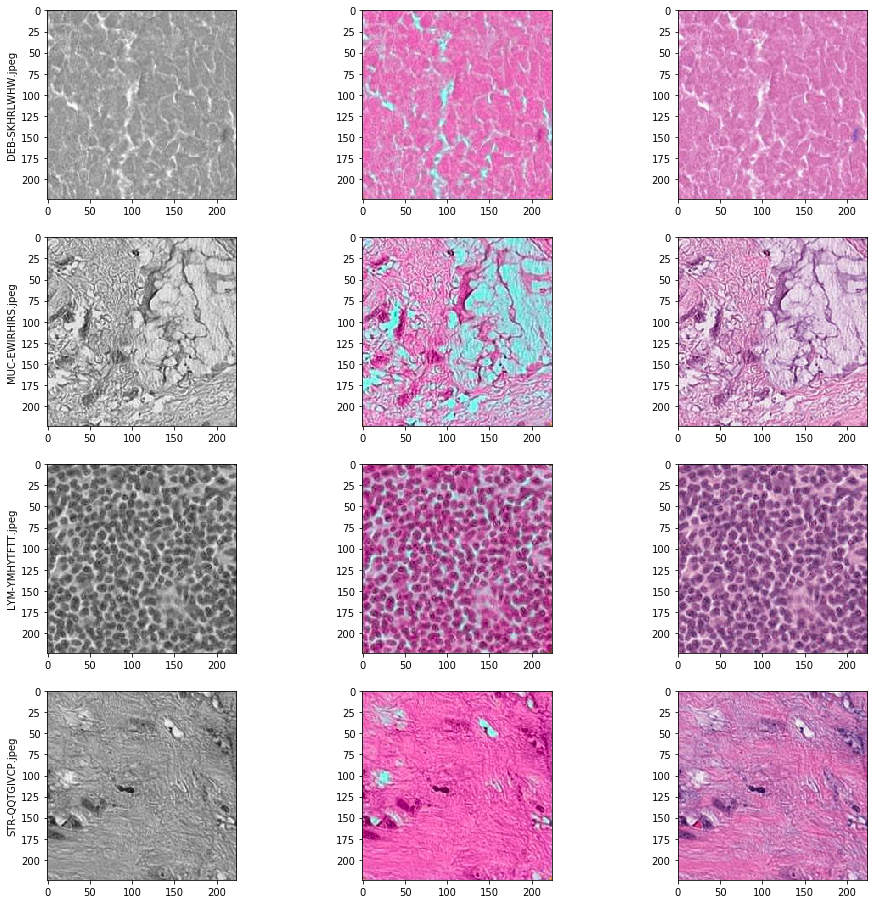

In [15]:
filelist = shuffle(os.listdir("results/predicted"))
filelist = filelist[:4]

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16,16))
row=0

for filename in filelist:
    folder = "results/bnw/"
    image_in = img_to_array(load_img(folder + filename))
    image_in = image_in/255.
    axes[row,0].imshow(image_in)
    axes[row,0].set_ylabel(filename)
    
    folder = "results/predicted/"
    image_in = img_to_array(load_img(folder + filename))
    image_in = image_in/255.
    axes[row,1].imshow(image_in)
    
    folder = "results/actual/"
    image_in = img_to_array(load_img(folder + filename))
    image_in = image_in/255.
    axes[row,2].imshow(image_in)

    row+=1

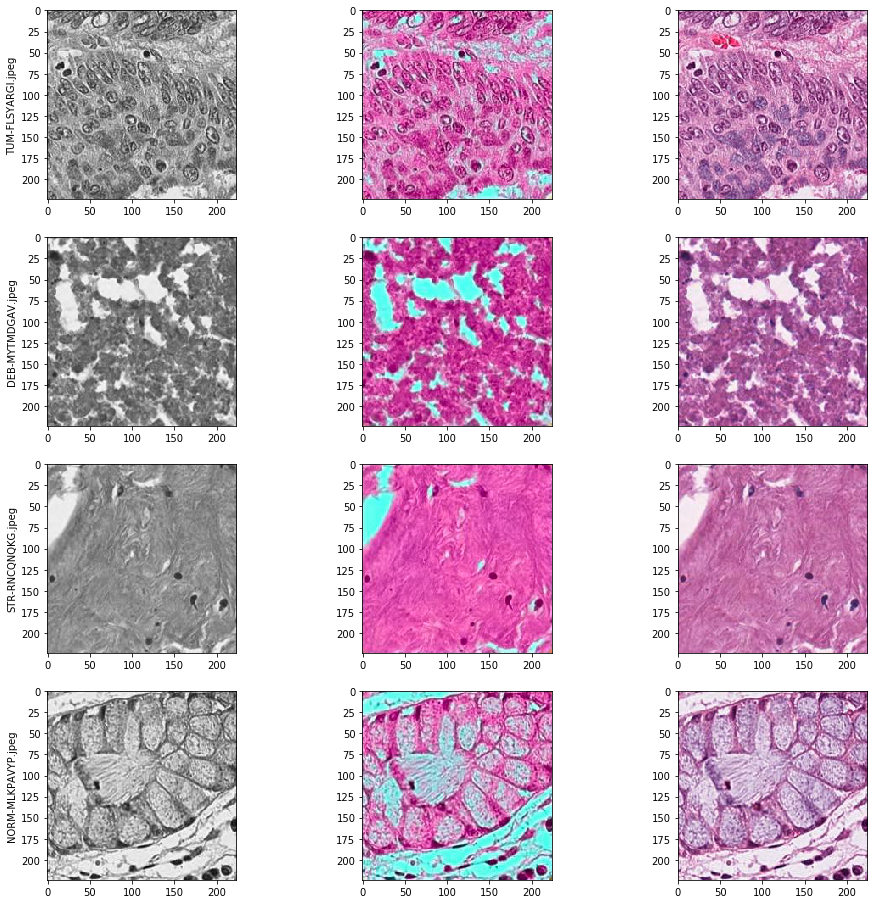

In [16]:
filelist = shuffle(os.listdir("results/predicted"))
filelist = filelist[:4]

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16,16))
row=0

for filename in filelist:
    folder = "results/bnw/"
    image_in = img_to_array(load_img(folder + filename))
    image_in = image_in/255.
    axes[row,0].imshow(image_in)
    axes[row,0].set_ylabel(filename)
    
    folder = "results/predicted/"
    image_in = img_to_array(load_img(folder + filename))
    image_in = image_in/255.
    axes[row,1].imshow(image_in)
    
    folder = "results/actual/"
    image_in = img_to_array(load_img(folder + filename))
    image_in = image_in/255.
    axes[row,2].imshow(image_in)

    row+=1

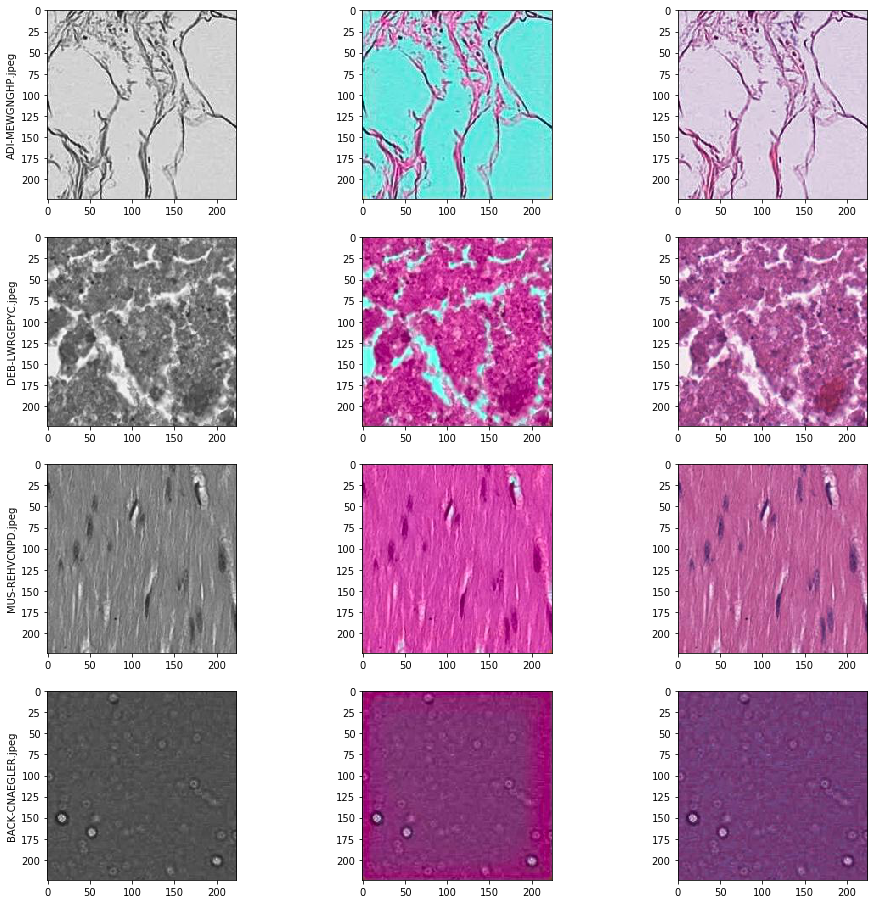

In [17]:
filelist = shuffle(os.listdir("results/predicted"))
filelist = filelist[:4]

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16,16))
row=0

for filename in filelist:
    folder = "results/bnw/"
    image_in = img_to_array(load_img(folder + filename))
    image_in = image_in/255.
    axes[row,0].imshow(image_in)
    axes[row,0].set_ylabel(filename)
    
    folder = "results/predicted/"
    image_in = img_to_array(load_img(folder + filename))
    image_in = image_in/255.
    axes[row,1].imshow(image_in)
    
    folder = "results/actual/"
    image_in = img_to_array(load_img(folder + filename))
    image_in = image_in/255.
    axes[row,2].imshow(image_in)

    row+=1